# `timex` example: Cradle-to-grave LCA of an electric vehicle

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import bw2data as bd

In [3]:
bd.projects.set_current('bw25_premise')

## Prospective databases
Created using `premise` with updated electricity sectors

In [4]:
db_2020 = bd.Database("db_2020")
db_2030 = bd.Database("db_2030")
db_2040 = bd.Database("db_2040")

## Case study setup

In [5]:
ELECTRICITY_CONSUMPTION = 0.2 # kWh/km
MILEAGE = 150_000 # km
LIFETIME = 15 # years
MASS_CAR = 1200 # kg
MASS_BATTERY = 280 # kg

In [6]:
del bd.databases['foreground']
foreground = bd.Database("foreground")
foreground.write({})

### Creating an EV activity considering the car production, battery production and electricity consumption

In [7]:
glider_production = bd.get_node(id=27559)
glider_production

'market for glider, passenger car' (kilogram, GLO, None)

In [8]:
powertrain_production = bd.get_node(id=46481) # eol included
powertrain_production

'market for powertrain, for electric passenger car' (kilogram, GLO, None)

In [9]:
battery_production = bd.get_node(id=41508)
battery_production

'battery production, Li-ion, LiMn2O4, rechargeable, prismatic' (kilogram, GLO, None)

In [10]:
electricity_production = bd.get_node(id=50069)
electricity_production

'market group for electricity, low voltage' (kilowatt hour, World, None)

In [11]:
glider_eol = bd.get_node(id=46589)
glider_eol

'market for manual dismantling of used electric passenger car' (unit, GLO, None)

In [12]:
battery_eol = bd.get_node(id=36946)
battery_eol

'market for used Li-ion battery' (kilogram, GLO, None)

In [13]:
fg = bd.Database('foreground')

In [14]:
fg.new_node("EV_lifecycle", name="Electric vehicle, lifecycle", unit="unit").save()

In [15]:
ev_lifecycle = fg.get("EV_lifecycle")
ev_lifecycle

'Electric vehicle, lifecycle' (unit, GLO, None)

In [16]:
ev_lifecycle.new_edge(                 
    input=ev_lifecycle,
    amount=1,
    type="production"
).save()

In [17]:
glider_production_exchange = ev_lifecycle.new_edge(                 
    input=glider_production,
    amount=(MASS_CAR - MASS_BATTERY) * .91264,
    type="technosphere"
)

In [18]:
powertrain_production_exchange = ev_lifecycle.new_edge(                 
    input=powertrain_production,
    amount=(MASS_CAR - MASS_BATTERY) * (1 - .91264),
    type="technosphere"
)

In [19]:
battery_production_exchange = ev_lifecycle.new_edge(                 
    input=battery_production,
    amount=MASS_BATTERY,
    type="technosphere"
)

In [20]:
electricity_production_exchange = ev_lifecycle.new_edge(                 
    input=electricity_production,
    amount=ELECTRICITY_CONSUMPTION * MILEAGE,
    type="technosphere"
)

In [21]:
glider_eol_exchange = ev_lifecycle.new_edge(                 
    input=glider_eol,
    amount=(MASS_CAR - MASS_BATTERY) * .91264, # amount not negative as its not modeled as a "true" waste process
    type="technosphere"
)

In [22]:
battery_eol_exchange = ev_lifecycle.new_edge(                 
    input=battery_eol,
    amount= - MASS_BATTERY,
    type="technosphere"
)

### Adding temporal distributions

In [23]:
from bw_temporalis import TemporalDistribution, easy_timedelta_distribution
import numpy as np

In [24]:
# defining Temporal Distributions of system
td_production = easy_timedelta_distribution(
                    start=-4,
                    end=0,
                    resolution="Y",  # M for months, Y for years, etc.
                    steps=5,
                    kind="triangular",
                    param=-1,
                )

td_use_phase =  easy_timedelta_distribution(
                    start=0, # (inclusive)
                    end=LIFETIME, # (inclusive)
                    resolution="Y",
                    steps= (LIFETIME + 1),  # Includes both start and end
                    kind = 'uniform' # Could also be "triangular" or "uniform"
                )

td_eol = TemporalDistribution(
            date=np.array([LIFETIME + 1], dtype='timedelta64[Y]'), #2023
            amount=np.array([1]))

In [25]:
glider_production_exchange['temporal_distribution'] = td_production
glider_production_exchange.save()

powertrain_production_exchange['temporal_distribution'] = td_production
powertrain_production_exchange.save()

battery_production_exchange['temporal_distribution'] = td_production
battery_production_exchange.save()

electricity_production_exchange['temporal_distribution'] = td_use_phase
electricity_production_exchange.save()

glider_eol_exchange['temporal_distribution'] = td_eol
glider_eol_exchange.save()

battery_eol_exchange['temporal_distribution'] = td_eol
battery_eol_exchange.save()

# LCA using `timex`

In [26]:
method = ('IPCC 2021 no LT',
 'climate change no LT',
 'global warming potential (GWP100) no LT')

In [27]:
from datetime import datetime

database_date_dict = {
    "db_2020": datetime.strptime("2020", "%Y"),
    "db_2030": datetime.strptime("2030", "%Y"),
    "db_2040": datetime.strptime("2040", "%Y"),
    "foreground": "dynamic",  # flag databases that should be temporally distributed with "dynamic"
}

In [28]:
from timex_lca import TimexLCA
tlca = TimexLCA({ev_lifecycle.key: 1}, method, database_date_dict, cutoff=1e-9)

Calculation count: 7


In [29]:
tlca.build_timeline()

,date_producer,producer_name,date_consumer,consumer_name,amount,interpolation_weights
0,2020-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",0.0,{'db_2020': 1}
1,2020-01-01,"battery production, Li-ion, LiMn2O4, rechargea...",2024-01-01,"Electric vehicle, lifecycle",0.0,{'db_2020': 1}
2,2020-01-01,"market for powertrain, for electric passenger car",2024-01-01,"Electric vehicle, lifecycle",0.0,{'db_2020': 1}
3,2021-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",139.938131,"{'db_2020': 0.8998083766767041, 'db_2030': 0.1..."
4,2021-01-01,"battery production, Li-ion, LiMn2O4, rechargea...",2024-01-01,"Electric vehicle, lifecycle",46.666667,"{'db_2020': 0.8998083766767041, 'db_2030': 0.1..."
5,2021-01-01,"market for powertrain, for electric passenger car",2024-01-01,"Electric vehicle, lifecycle",13.3952,"{'db_2020': 0.8998083766767041, 'db_2030': 0.1..."
6,2022-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",279.876261,"{'db_2020': 0.7998905009581166, 'db_2030': 0.2..."
7,2022-01-01,"battery production, Li-ion, LiMn2O4, rechargea...",2024-01-01,"Electric vehicle, lifecycle",93.333333,"{'db_2020': 0.7998905009581166, 'db_2030': 0.2..."
8,2022-01-01,"market for powertrain, for electric passenger car",2024-01-01,"Electric vehicle, lifecycle",26.7904,"{'db_2020': 0.7998905009581166, 'db_2030': 0.2..."
9,2023-01-01,"market for glider, passenger car",2024-01-01,"Electric vehicle, lifecycle",419.814392,"{'db_2020': 0.6999726252395291, 'db_2030': 0.3..."


In [30]:
tlca.build_datapackage()
tlca.lci()
tlca.lcia()

In [31]:
co2_flows = [flow for flow in bd.Database('biosphere3') if 'Carbon dioxide' in flow['name'] and "air" in flow['categories']]
co2_flow_codes = [flow.key[1] for flow in co2_flows]
co2_flow_ids = [flow.id for flow in co2_flows]

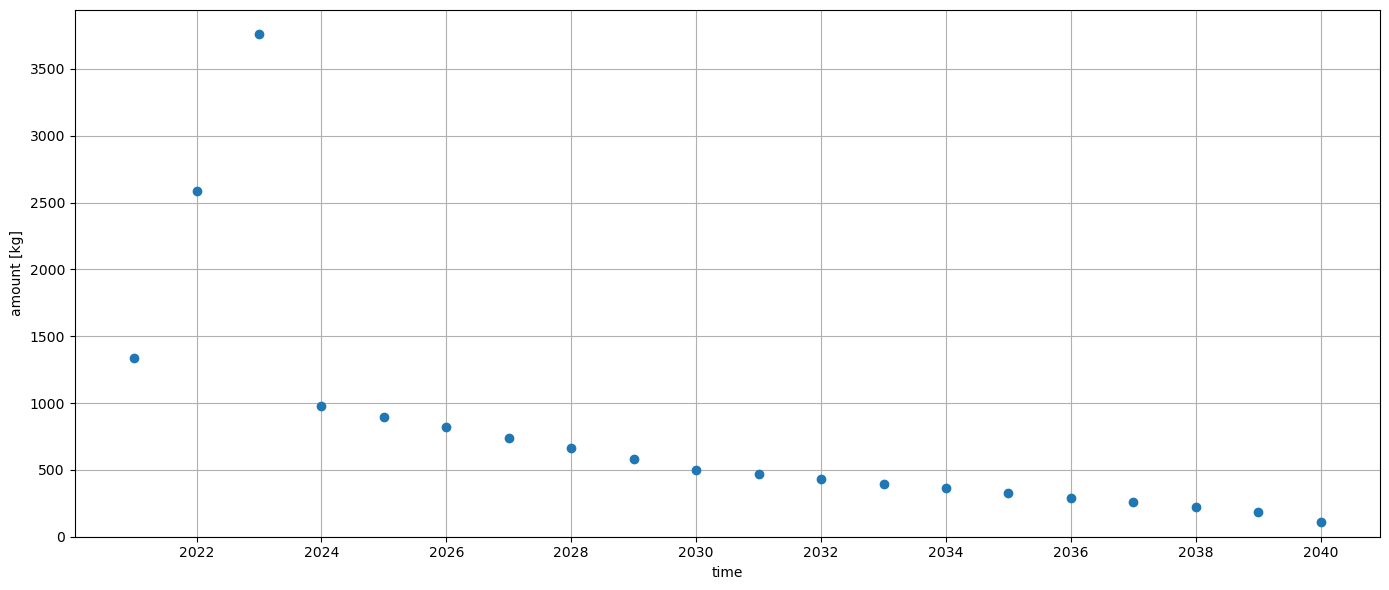

In [32]:
tlca.plot_dynamic_inventory(bio_flows=co2_flow_codes, cumulative=False)

In [33]:
from timex_lca.utils import add_flows_to_characterization_function_dict
from timex_lca.dynamic_characterization import characterize_co2

In [34]:
cf_dict = add_flows_to_characterization_function_dict(co2_flow_ids, characterize_co2)

In [35]:
tlca.characterize_dynamic_lci(type="radiative_forcing", fixed_TH=True, characterization_functions=cf_dict)

,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2021-01-01 00:00:00,0.000000e+00,112,"Carbon dioxide, fossil",98281.0,"(db_2020, 133b33cc867081af144475d62179286b)",0.000000e+00
29,2021-01-01 00:00:00,0.000000e+00,3642,"Carbon dioxide, from soil or biomass stock",98283.0,"(db_2020, f6d3f0b01e4a38c055e3c5c1356a4bba)",0.000000e+00
28,2021-01-01 00:00:00,0.000000e+00,1170,"Carbon dioxide, fossil",98282.0,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",0.000000e+00
27,2021-01-01 00:00:00,0.000000e+00,1171,"Carbon dioxide, fossil",98283.0,"(db_2020, f6d3f0b01e4a38c055e3c5c1356a4bba)",0.000000e+00
26,2021-01-01 00:00:00,0.000000e+00,114,"Carbon dioxide, non-fossil",98282.0,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",0.000000e+00
...,...,...,...,...,...,...,...
25654,2123-01-01 20:31:12,-2.873470e-14,1171,"Carbon dioxide, fossil",98307.0,"(db_2020, fec93a95a9a84d7fa0ede9c3082bb79f)",1.386906e-09
25655,2123-01-01 20:31:12,4.478184e-20,1169,"Carbon dioxide, fossil",98307.0,"(db_2020, fec93a95a9a84d7fa0ede9c3082bb79f)",1.386906e-09
25656,2123-01-01 20:31:12,2.603391e-15,3642,"Carbon dioxide, from soil or biomass stock",98307.0,"(db_2020, fec93a95a9a84d7fa0ede9c3082bb79f)",1.386909e-09
25657,2123-01-01 20:31:12,1.202430e-16,1164,"Carbon dioxide, non-fossil",98307.0,"(db_2020, fec93a95a9a84d7fa0ede9c3082bb79f)",1.386909e-09


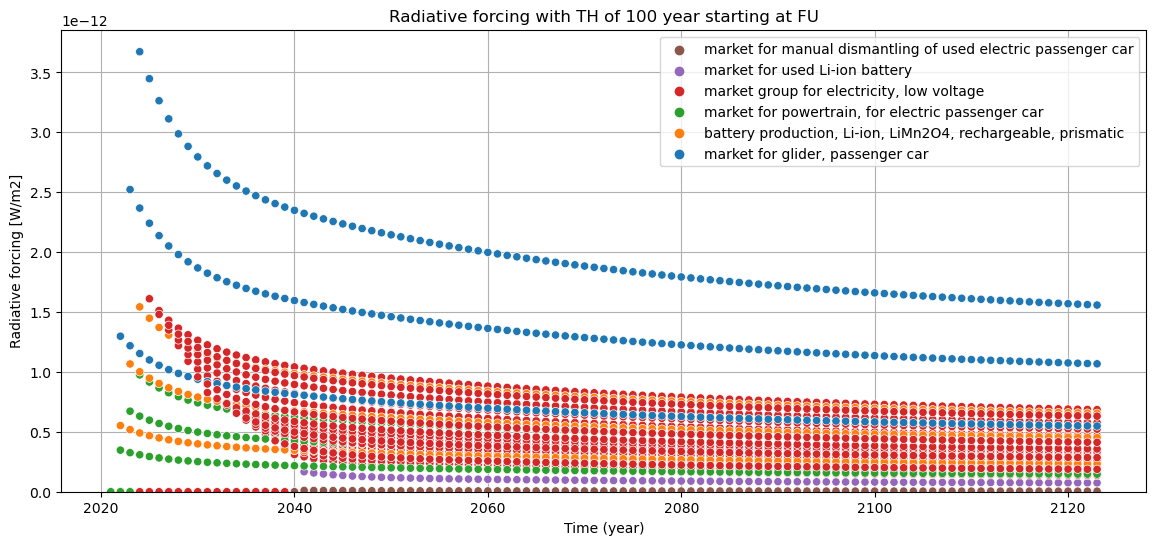

In [36]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True)

In [37]:
tlca.characterize_dynamic_lci(type="GWP", fixed_TH=True, characterization_functions=cf_dict)

,date,amount,flow,flow_name,activity,activity_name,amount_sum
0,2021-01-01,194.266946,112,"Carbon dioxide, fossil",98281.0,"(db_2020, 133b33cc867081af144475d62179286b)",194.266946
29,2021-01-01,0.000014,1169,"Carbon dioxide, fossil",98282.0,"(db_2020, ba87aff6361d99be2636e8c59e55a5b2)",1365.667672
28,2021-01-01,203.070505,1171,"Carbon dioxide, fossil",98281.0,"(db_2020, 133b33cc867081af144475d62179286b)",1365.667658
27,2021-01-01,0.000037,1169,"Carbon dioxide, fossil",98281.0,"(db_2020, 133b33cc867081af144475d62179286b)",1162.597153
26,2021-01-01,44.871593,112,"Carbon dioxide, fossil",98283.0,"(db_2020, f6d3f0b01e4a38c055e3c5c1356a4bba)",1162.597116
...,...,...,...,...,...,...,...
251,2040-01-01,1.254845,1164,"Carbon dioxide, non-fossil",98310.0,"(db_2020, 82ebcdf42e8512cbe00151dda6210d29)",15567.992163
250,2040-01-01,0.002822,3632,"Carbon dioxide, from soil or biomass stock",98310.0,"(db_2020, 82ebcdf42e8512cbe00151dda6210d29)",15566.737317
268,2040-01-01,26.898184,112,"Carbon dioxide, fossil",98310.0,"(db_2020, 82ebcdf42e8512cbe00151dda6210d29)",15660.662537
258,2040-01-01,0.000002,1170,"Carbon dioxide, fossil",98310.0,"(db_2020, 82ebcdf42e8512cbe00151dda6210d29)",15627.157355


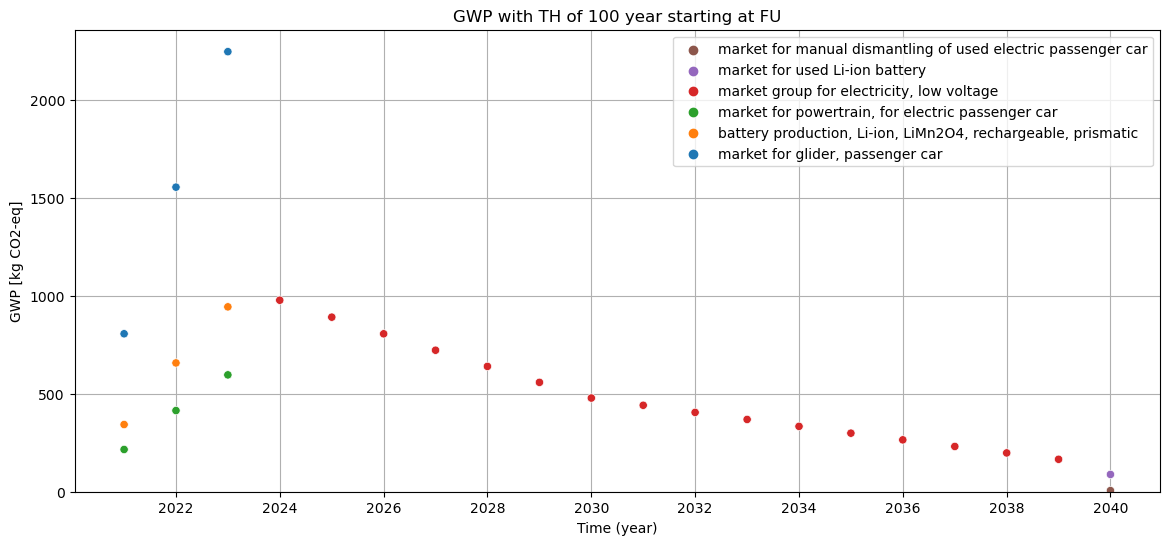

In [38]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True, cumsum=False)

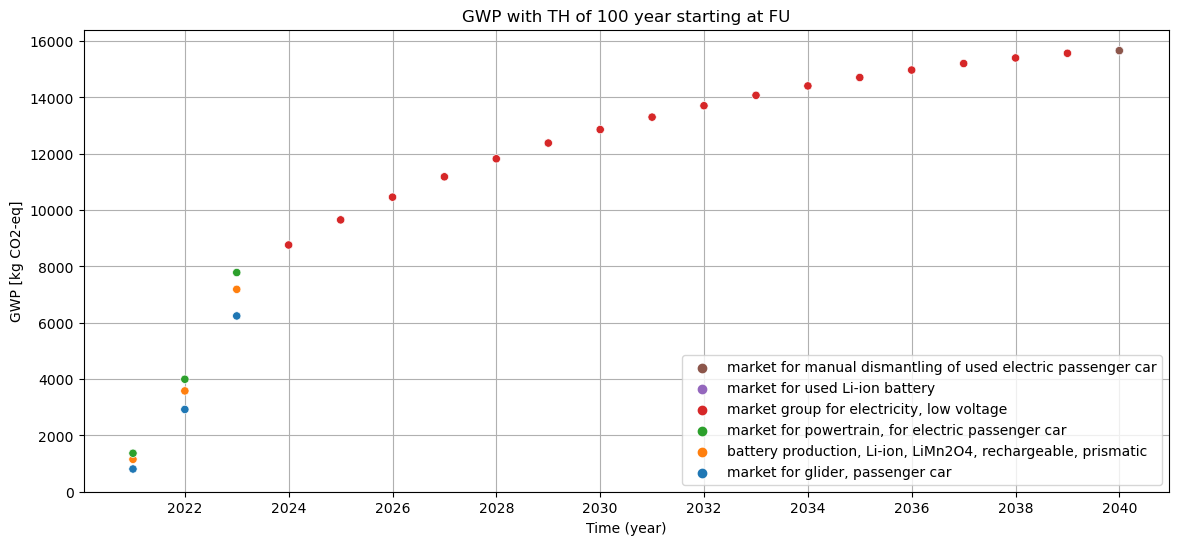

In [39]:
tlca.plot_dynamic_characterized_inventory(sum_emissions_within_activity=True, cumsum=True)

In [40]:
import bw2calc as bc

static_scores = {}
for e in ev_lifecycle.exchanges():
    if e.input == ev_lifecycle.key:
        continue
    lca = bc.LCA({e.input: e.amount}, method)
    lca.lci()
    lca.lcia()
    static_scores[e.input['name']] = lca.score
    

In [41]:
prospective_ev_lifecycle = ev_lifecycle.copy()

In [42]:
for exc in prospective_ev_lifecycle.exchanges():
    if exc.input == prospective_ev_lifecycle:
        continue
    exc.input = bd.get_node(
                            **{
                                "database": "db_2040",
                                "name": exc.input["name"],
                                "product": exc.input["reference product"],
                                "location": exc.input["location"],
                            }
                        )
    exc.save()

In [43]:
prospective_scores = {}
for e in prospective_ev_lifecycle.exchanges():
    if e.input == prospective_ev_lifecycle.key:
        continue
    lca = bc.LCA({e.input: e.amount}, method)
    lca.lci()
    lca.lcia()
    prospective_scores[e.input['name']] = lca.score

In [44]:
from timex_lca.utils import plot_characterized_inventory_as_waterfall

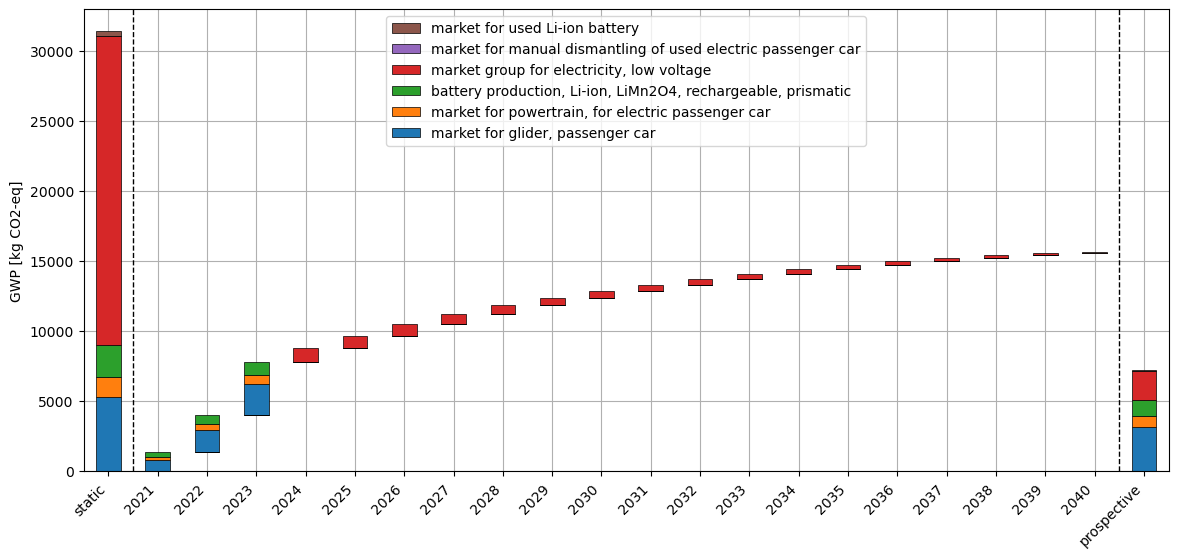

In [45]:
plot_characterized_inventory_as_waterfall(tlca.characterized_inventory, static_scores=static_scores, prospective_scores=prospective_scores)